In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('../../churn-prediction/customers_data.csv')

In [3]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

str_cols = list(df.dtypes[df.dtypes == 'object'].index)

for col in str_cols:
    df[col] = df[col].str.lower().str.replace(" ", "_")
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(full_train, test_size=0.25, random_state=1)

In [5]:
y_test = df_test.churn.values
y_valid = df_valid.churn.values
y_train = df_train.churn.values

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

del df_test['churn']
del df_valid['churn']
del df_train['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
valid_dict = df_valid[numerical + categorical].to_dict(orient='records')
X_valid = dv.transform(valid_dict)

prediction = model.predict_proba(X_valid)

soft_prediction = model.predict_proba(X_valid)[:, 1]

In [22]:
churn_decision = (soft_prediction >= 0.5)

(churn_decision == y_valid).mean()

0.8034066713981547

# Accuracy and dummy model

In [12]:
len(y_valid)

1409

In [13]:
(y_valid == churn_decision).sum()
# absolute value

1132

In [14]:
thresholds = np.linspace(0, 1, 21)

thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [15]:
scores = []

for t in thresholds:
    churn_decision = (soft_prediction >= t)
    score = (y_valid == churn_decision).mean()
    scores.append(score)

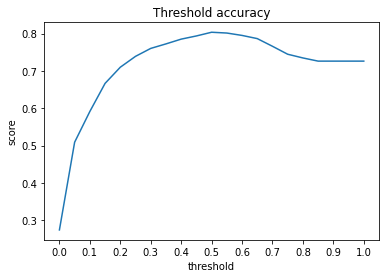

In [21]:
plt.plot(thresholds, scores)
plt.title('Threshold accuracy')
plt.xlabel('threshold')
plt.ylabel('score')

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [24]:
# doing via sklearn
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, soft_prediction >= 0.5)

0.8034066713981547

In [25]:
y_valid.mean()
# 27% are churning

0.2739531582682754

In [26]:
1 - y_valid.mean()
# 72% are non-churning

0.7260468417317246

In [29]:
length = len(y_valid)
baseline = np.repeat(False, length)

In [31]:
round(accuracy_score(baseline, y_valid, ), 3)

0.726

# Confusion table

In [32]:
actual_positive = (y_valid == 1)
actual_negative = (y_valid == 0)

In [33]:
t = 0.5

prediction_positive = (soft_prediction >= t)
prediction_negative = (soft_prediction < t)

In [34]:
true_positive = (actual_positive & prediction_positive).sum()
true_negative = (actual_negative & prediction_negative).sum()

false_positive = (actual_negative & prediction_positive).sum()
false_negative = (actual_positive & prediction_negative).sum()

In [35]:
               # predictions
          # neg              pos
c_t = np.array([
        [true_negative, false_positive],    # neg   # actual values
        [false_negative, true_positive]     # pos
])                
                 

In [36]:
c_t
# false_positive is when customer doesn't churn, but we predict as churn
# false_negative is when customer does churn, but we predict as no-churn

array([[922, 101],
       [176, 210]])

In [39]:
c_t * 100 / c_t.sum()
# normalize it -> get relative numbers

array([[65.43647977,  7.1682044 ],
       [12.49112846, 14.90418737]])

In [40]:
# we can get our accuracy from confusion table
(65.43647977 + 14.90418737) / (65.43647977 + 14.90418737 + 12.49112846 + 7.1682044)

0.8034066714000001

# Precision and Recall

In [42]:
p = 210 / (101 + 210)

In [43]:
p
# 33% are mistaken customers who are not supposed to get email

0.6752411575562701

In [44]:
r = 210 / (210 + 176)

In [45]:
r
# so, 46% of churning customers are not identified

0.5440414507772021

# ROC Curve